

# Team Members
- Rama Alyoubi, ID: 2110112
- Rimas Alshehri, ID: 2110240
- Ryouf Alghamdi, ID: 2110489


---


# Domain

The dataset is from the domain of religious texts, specifically the collection of Hadith which are sayings, actions, and approvals of the Prophet Muhammad (peace be upon him).

---



# Dataset Source

The dataset can be accessed via Kaggle at the following link: [Hadith Dataset on Kaggle](https://www.kaggle.com/datasets/fahd09/hadith-dataset)

---

# Data Description

The dataset comprises collections of Hadith from six primary sources: Sahih Muslim, Sahih Bukhari, Sunan an-Nasa'i, Sunan Abi Da'ud, Sunan Ibn Majah, and Jami' al-Tirmidhi. The data is presented in both Arabic and English, containing information about the source, chapter number, hadith number, the text of the hadiths in Arabic and English, and chain indexes that trace the narrators of each hadith.

---

# 1. Setup

## 1.1  Installing Necessary Libraries

In [ ]:
!pip install transformers flask pandas scikit-learn

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!echo '{"username":"ramaalyoubi","key":"82e22c4988257fba9141f3be474f0b66"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fahd09/hadith-dataset
!unzip hadith-dataset.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
hadith-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  hadith-dataset.zip
replace all_hadiths_clean.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install langdetect

## 1.2 Importing Libraries

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from langdetect import detect
import re


# 2. Data Loading

In [ ]:
# Load the dataset
df = pd.read_csv('all_hadiths_clean.csv')

# 3. Data Preprocessing

## 3.1 Cleaning

In [ ]:
# Normalize the text
df['text_en'] = df['text_en'].str.lower().str.replace('[^\w\s]', '') #Normalizes the English text by converting it to lower case and removing all punctuation using a regular expression that keeps only word characters and spaces.

<ipython-input-35-09c1759b031e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text_en'] = df['text_en'].str.lower().str.replace('[^\w\s]', '')


In [ ]:
# Check for missing values and handle them
df.dropna(subset=['text_ar', 'text_en'], inplace=True)

In [ ]:
from langdetect import detect, LangDetectException #which are used for detecting the language of a given text and handling any language detection errors, respectively.


def remove_english_words(chapter_name):
    # Split the chapter name into Arabic and English parts
    parts = chapter_name.split(' and ') # besead on

    # Filter out the Arabic part
    arabic_part = parts[0] #Takes the first part from the split as the Arabic portion.

    # Remove any remaining English words using regex
    cleaned_chapter_name = re.sub(r'\b\w+\b', '', arabic_part).strip() # function is used to remove leading and trailing spaces.

    return cleaned_chapter_name

# Apply function to remove English words from chapter names
df["chapter"] = df["chapter"].apply(lambda x: remove_english_words(x))


In [ ]:
# Define dataset class
class HadithDataset(Dataset): #Defines a new class HadithDataset that inherits from PyTorch's Dataset class. This class is tailored for handling the hadith dataset specifically.
    def __init__(self, texts, chapters, tokenizer, max_length):
        self.texts = texts
        self.chapters = chapters
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self): #Returns the number of texts
        return len(self.texts)

    def __getitem__(self, idx): #Retrieves an item from the dataset by its index
        text = self.texts[idx]
        chapter = self.chapters[idx]
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt') #'pt' stands for PyTorch tensor
        return {
            'input_ids': encoding['input_ids'].squeeze(),# to remove any extra dimensions from the tensors
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(chapter)
        }

In [ ]:
# Define dataset class for Approach 2
class HadithDataset2(Dataset): # Defines a new class called HadithDataset2 that inherits from PyTorch's Dataset class.
    def __init__(self, texts, tokenizer, max_length): #initializes the dataset with three parameters
        self.texts = texts #A list of texts to be processed
        self.tokenizer = tokenizer # tokenizer that prepares the texts for input into a model.
        self.max_length = max_length # The maximum allowed length for the tokenized output to ensure uniformity in tensor sizes.

    def __len__(self):# get the number of items importent in training or evaluation.
        return len(self.texts)

    def __getitem__(self, idx): # Retrieves an item from the dataset using its index.
        text = self.texts[idx] # Extracts the text at the specified index
        encoding = self.tokenizer.encode_plus( #Tokenizes the text. method is used here to get a more detailed configuration
            text,
            add_special_tokens=True,
            max_length=self.max_length, #يتاكد ان كل المخرجات لها نفس الطول
            padding='max_length',
            truncation=True,
            return_tensors='pt' #Ensures the output is a PyTorch tensor
        )
        input_ids = encoding['input_ids'].squeeze(0)  # Removes the batch dimension that is added by default when return_tensors='pt' is used.
        attention_mask = encoding['attention_mask'].squeeze(0) #removes the batch dimension from the attention mask.
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

## 3.2 EDA

In [ ]:
#checking the first few rows of the dataset
df.head()

,id,hadith_id,source,chapter_no,hadith_no,chapter,chain_indx,text_ar,text_en
0,0,1,Sahih Bukhari,1,1,Revelation - كتاب بدء الوحى,"30418, 20005, 11062, 11213, 11042, 3",حدثنا الحميدي عبد الله بن الزبير، قال حدثنا سف...,Narrated 'Umar bin Al-Khattab: ...
1,1,2,Sahih Bukhari,1,2,Revelation - كتاب بدء الوحى,"30355, 20001, 11065, 10511, 53",حدثنا عبد الله بن يوسف، قال أخبرنا مالك، عن هش...,Narrated 'Aisha: ...
2,2,3,Sahih Bukhari,1,3,Revelation - كتاب بدء الوحى,"30399, 20023, 11207, 11013, 10511, 53",حدثنا يحيى بن بكير، قال حدثنا الليث، عن عقيل، ...,Narrated 'Aisha: (the m...
3,3,4,Sahih Bukhari,1,4,Revelation - كتاب بدء الوحى,"11013, 10567, 34",قال ابن شهاب وأخبرني أبو سلمة بن عبد الرحمن، أ...,Narrated Jabir bin 'Abdullah Al-Ansari while ...
4,4,5,Sahih Bukhari,1,5,Revelation - كتاب بدء الوحى,"20040, 20469, 11399, 11050, 17",حدثنا موسى بن إسماعيل، قال حدثنا أبو عوانة، قا...,Narrated Said bin Jubair: ...


In [ ]:
# displaying a summary of dataframe including the data types and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34441 entries, 0 to 34440
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          34441 non-null  int64 
 1   hadith_id   34441 non-null  int64 
 2   source      34441 non-null  object
 3   chapter_no  34441 non-null  int64 
 4   hadith_no   34441 non-null  object
 5   chapter     34441 non-null  object
 6   chain_indx  34318 non-null  object
 7   text_ar     34433 non-null  object
 8   text_en     33588 non-null  object
dtypes: int64(3), object(6)
memory usage: 2.4+ MB


In [ ]:
#displaying a descriptive statistics for numerical columns
df.describe()

,id,hadith_id,chapter_no
count,34441.000000,34441.000000,34441.000000
mean,174.949188,24558.251677,29.603467
std,607.052596,16983.092973,23.002504
min,0.000000,1.000000,0.000000
25%,28.000000,10959.000000,10.000000
50%,74.000000,22262.000000,25.000000
75%,158.000000,41391.000000,45.000000
max,7695.000000,54227.000000,98.000000


In [ ]:
# displaying the count of unique values in 'source' and 'chapter' columns
print(df['source'].nunique())
print(df['chapter'].nunique())

6
330


In [ ]:
#displaying the frequency of each unique value in 'source' column
print(df['source'].value_counts())

source
Sahih Muslim          7596
Sahih Bukhari         7370
Sunan an-Nasa'i       5774
Sunan Abi Da'ud       5260
Sunan Ibn Majah       4227
Jami' al-Tirmidhi     4214
Name: count, dtype: int64


In [ ]:
#displaying the frequency of each unique value in 'chapter'
print(df['chapter'].value_counts())

chapter
Prayer (Kitab Al-Salat) - كتاب الصلاة                                                    771
Establishing the Prayer and the Sunnah Regarding Them - كتاب إقامة الصلاة والسنة فيها    648
The Book of Fasting - كتاب الصيام                                                        629
The Book of Pilgrimage - كتاب الحج                                                       620
Prophetic Commentary on the Qur'an (Tafseer of the Prophet (pbuh)) - كتاب التفسير        509
                                                                                        ... 
Makaatib - كتاب المكاتب                                                                    6
Fear Prayer - كتاب صلاة الخوف                                                              6
Praying at Night in Ramadaan (Taraweeh) - كتاب صلاة التراويح                               6
Transferance of a Debt from One Person to Another (Al-Hawaala) - كتاب الحوالات             3
Shuf'a - كتاب الشفعة                                          

In [ ]:
# Drop rows where 'text_ar' is NaN
print("Original size:", df.shape)
df = df.dropna(subset=['text_ar'])
print("Filtered size:", df.shape)

Original size: (34441, 9)
Filtered size: (34433, 9)


In [ ]:
#the count of missing values in each column
df.isnull().sum()

id              0
hadith_id       0
source          0
chapter_no      0
hadith_no       0
chapter         0
chain_indx    123
text_ar         8
text_en       853
dtype: int64

In [ ]:
df.dropna(subset=['chain_indx'], inplace=True)

In [ ]:
df.isnull().sum()

id              0
hadith_id       0
source          0
chapter_no      0
hadith_no       0
chapter         0
chain_indx      0
text_ar         0
text_en       782
dtype: int64

In [ ]:
df.dropna(subset=['text_en'], inplace=True)

In [ ]:
df.isnull().sum()

id            0
hadith_id     0
source        0
chapter_no    0
hadith_no     0
chapter       0
chain_indx    0
text_ar       0
text_en       0
dtype: int64

In [ ]:
#checking the length of text in both Arabic and English
df['text_ar_length'] = df['text_ar'].apply(len)
df['text_en_length'] = df['text_en'].apply(len)

In [ ]:
#the length of text in Arabic
df['text_ar_length']

0         372
1         483
2        1693
3         471
4         697
         ... 
34436     303
34437     233
34438     266
34439     272
34440     287
Name: text_ar_length, Length: 33536, dtype: int64

In [ ]:
#the length of text in English
df['text_en_length']

0         342
1         651
2        2973
3         705
4        1354
         ... 
34436     295
34437     222
34438     296
34439     296
34440     361
Name: text_en_length, Length: 33536, dtype: int64

In [ ]:
# the average length of text in both Arabic and English
print(df[['text_ar_length', 'text_en_length']].mean())

text_ar_length    346.208224
text_en_length    435.213800
dtype: float64


In [ ]:
#count of unique chains'chain is an 'identifier'
print(df['chain_indx'].nunique())

27809


In [ ]:
#frequency of each chain index (chain index is a categorical representation of each chain)
print(df['chain_indx'].value_counts())

chain_indx
30375, 20121, 20115, 11447, 13                         67
30216, 20318, 11325, 11901, 41                         51
30367, 20023, 11014, 18                                46
30355, 20001, 11014, 18                                45
30399, 11014, 18                                       44
                                                       ..
30128, 20022, 11269                                     1
30128, 30367, 20022, 30137, 20022, 11015, 11047, 19     1
30201, 20354, 20032, 30212, 20331, 30200, 20326         1
30022, 30203, 20028, 11060, 11353, 11018                1
36540, 20596, 11060, 11161, 38                          1
Name: count, Length: 27809, dtype: int64


# Visualizations


Visual representations from the dataset show the following:
1. A word cloud highlighting the most frequent words in English Hadith texts such as "Allah," "Prophet," "Messenger," "peace," "narrated," "said," and "upon."
2. A bar chart detailing the count of Hadiths by source, indicating Sahih Muslim and Sahih Bukhari as the most prominent collections in the dataset.
3. A density plot illustrating the distribution of text lengths, showing that English translations are generally longer than the Arabic texts.
4. A bar chart displaying the cumulative count of Hadiths over chapters, reflecting a concentration in certain chapters.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


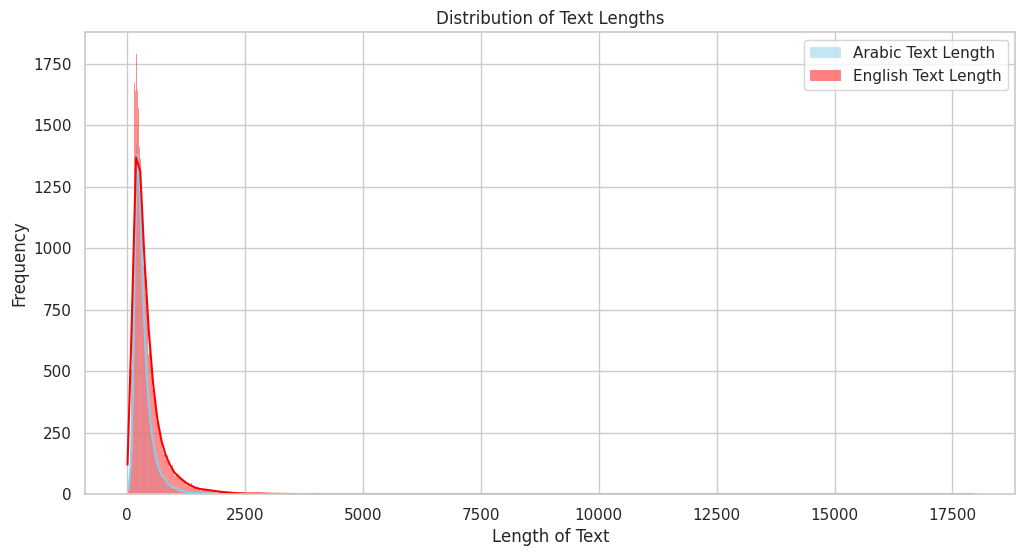

In [ ]:
#Distribution of Text Lengths in both Arabic and English
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Histogram of text lengths
plt.figure(figsize=(12, 6))
sns.histplot(df['text_ar_length'], color="skyblue", label='Arabic Text Length', kde=True)
sns.histplot(df['text_en_length'], color="red", label='English Text Length', kde=True)
plt.legend()
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()

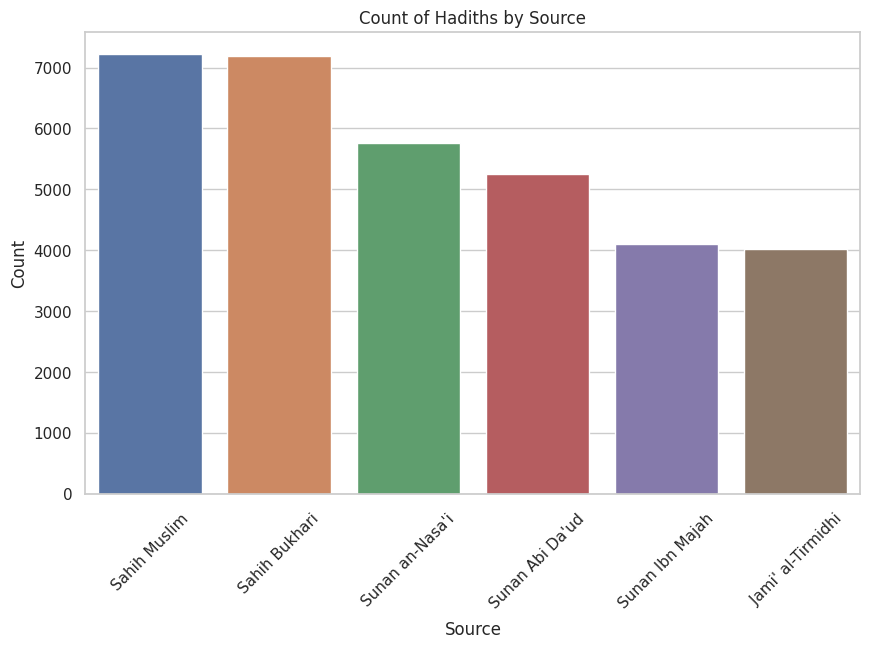

In [ ]:
# Count Plot for Sources to ompare of the frequency of Hadiths from each source
plt.figure(figsize=(10, 6))
sns.countplot(x='source', data=df, order = df['source'].value_counts().index)
plt.title('Count of Hadiths by Source')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

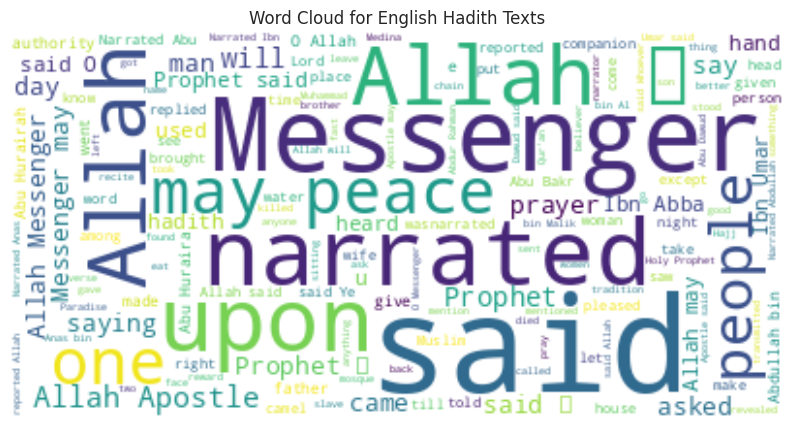

In [ ]:
#Word Clouds for Textual Data to visualize the most common words
from wordcloud import WordCloud

# Generate a word cloud image for English Text
wordcloud_en = WordCloud(background_color="white").generate(' '.join(df['text_en']))

# Display the generated image:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_en, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for English Hadith Texts')
plt.show()

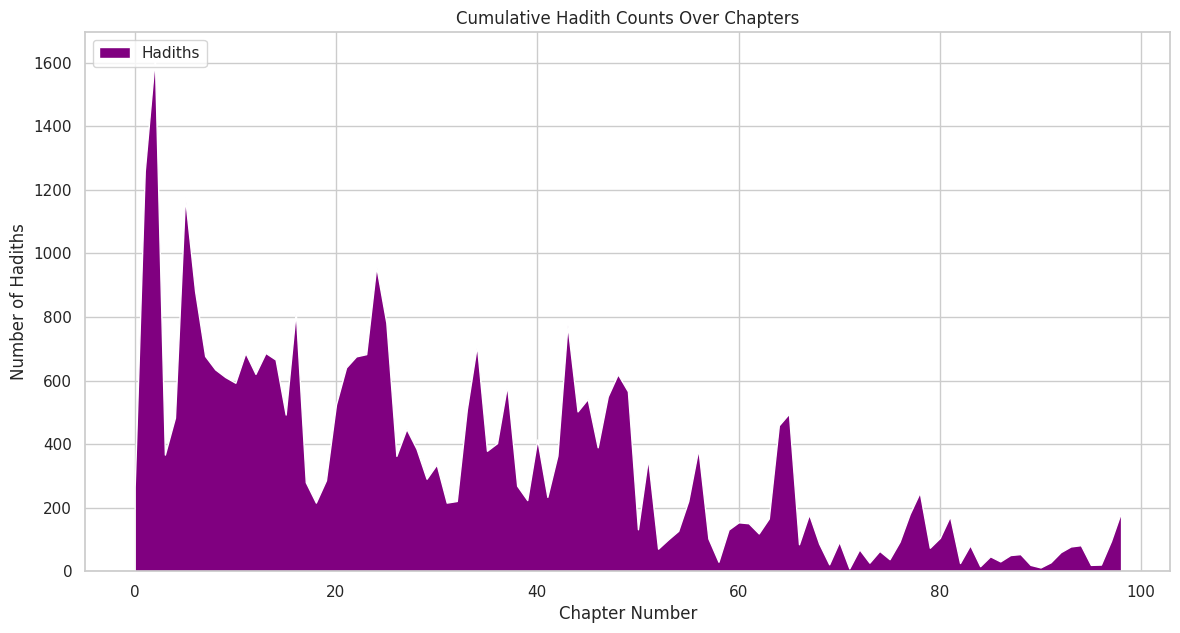

In [ ]:
# Stacked Area Chart for Hadiths Over Chapters to visualize the cumulative number of Hadiths across different chapters
chapter_counts = df.groupby('chapter_no').size()

plt.figure(figsize=(14, 7))
plt.stackplot(chapter_counts.index, chapter_counts, labels=['Hadiths'], colors=['purple'])
plt.title('Cumulative Hadith Counts Over Chapters')
plt.xlabel('Chapter Number')
plt.ylabel('Number of Hadiths')
plt.legend(loc='upper left')
plt.show()

# Splitting

##Word Embedding Approach

In [ ]:
# Split the dataset into train and validation sets
train_texts, val_texts, train_chapters, val_chapters = train_test_split(df['text_ar'], df['chapter'], test_size=0.2, random_state=42) #These specify the columns from the DataFrame df that will be used as features (Arabic texts) and labels (chapters) respectively.

In [ ]:
from transformers import AutoTokenizer, AutoModel #These are used to handle tokenization and model loading.

tokenizer = AutoTokenizer.from_pretrained("aubmindlab/aragpt2-base") # This tokenizer is configured to match the tokenization used in the "aragpt2-base"
model = AutoModel.from_pretrained("aubmindlab/aragpt2-base")


In [ ]:
# Define dataset and dataloaders (These are PyTorch DataLoader instances that manage batches of data from the datasets)
train_dataset = HadithDataset(train_texts.tolist(), train_chapters.tolist(), tokenizer, max_length=128)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True) #training dataloader shuffles the data (to ensure randomization)

val_dataset = HadithDataset(val_texts.tolist(), val_chapters.tolist(), tokenizer, max_length=128)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False) #val dataloader not shuffles the data (to ensure consistent evaluation)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #يشيك اذا cuda متاح راح يستخدم  gpu
model.to(device)

GPT2Model(
  (wte): Embedding(64000, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

##Train Last Layer Approach

In [ ]:
from transformers import AutoTokenizer, GPT2LMHeadModel

tokenizer = AutoTokenizer.from_pretrained("aubmindlab/aragpt2-base")
model = GPT2LMHeadModel.from_pretrained("aubmindlab/aragpt2-base")

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    # Resize model embedding to account for new token
    model.resize_token_embeddings(len(tokenizer))

In [ ]:
# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the language modeling head
for param in model.lm_head.parameters():
    param.requires_grad = True

In [ ]:
# Define dataset and dataloaders
texts = df['text_ar'].tolist()
train_texts, val_texts = train_test_split(df['text_ar'].tolist(), test_size=0.2, random_state=42)  # 20% for validation
train_dataset = HadithDataset2(train_texts, tokenizer, max_length=128)
val_dataset = HadithDataset2(val_texts, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(64001, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=64001, bias=False)
)

# 4. Model Training

##Word Embedding Approach

In [ ]:
import torch # Imported for using PyTorch, a deep learning framework.
import numpy as np

# Function to encode text to embeddings using the last hidden state of the model
def encode_text_with_labels(texts, labels, model, tokenizer, max_length=None, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval() # ensures the model is in evaluation mode, deactivating dropout and batch normalization layers during inference.

    all_embeddings = []
    all_labels = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_labels = labels[i:i+batch_size] # Ignore this step #Batch Processing: Texts are processed in batches to manage memory usage and improve performance. Each batch is tokenized and then fed into the model.
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device) #converts text batches into a format suitable for the model

        with torch.no_grad(): #يقلل استهلاك الذاكرة و يسرع العمليات الحسابيه
            outputs = model(**encoded_input)
            # Get the embeddings from the last hidden state
            embeddings = outputs.last_hidden_state[:, -1, :].detach().cpu().numpy()
            all_embeddings.append(embeddings)
            all_labels.extend(batch_labels)

    # Concatenate all batch embeddings
    all_embeddings = np.concatenate(all_embeddings, axis=0) #Embeddings are collected into a list, detached from GPU, converted to NumPy arrays
    return all_embeddings, all_labels

# Define a padding token for the tokenizer
tokenizer.pad_token = tokenizer.eos_token

batch_size = 32
max_length = 256
# Generate embeddings for each Hadith without labels
embeddings, _ = encode_text_with_labels(df['text_ar'].tolist(), df['chapter'].tolist(), model, tokenizer, max_length=max_length, batch_size=batch_size)

##Train Last Layer Approach

In [ ]:
# Set up the optimizer
optimizer = AdamW(model.lm_head.parameters(), lr=2e-5)


In [ ]:
def train_model(model, train_loader, val_loader, optimizer):
    model.train()
    for epoch in range(3):
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f"Epoch {epoch+1}, Training Loss: {loss.item()}")

        validate_model(model, val_loader)

def validate_model(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            total_loss += loss.item()

        average_loss = total_loss / len(val_loader)
        print(f"Validation Loss: {average_loss}")
train_model(model, train_loader, val_loader, optimizer)

Streaming output truncated to the last 5000 lines.
Epoch 2, Training Loss: 1.7148805856704712
Epoch 2, Training Loss: 1.5598995685577393
Epoch 2, Training Loss: 1.712628722190857
Epoch 2, Training Loss: 1.8108543157577515
Epoch 2, Training Loss: 2.117842435836792
Epoch 2, Training Loss: 1.7179157733917236
Epoch 2, Training Loss: 1.8956698179244995
Epoch 2, Training Loss: 1.6480388641357422
Epoch 2, Training Loss: 1.8050447702407837
Epoch 2, Training Loss: 1.9931459426879883
Epoch 2, Training Loss: 2.05779767036438
Epoch 2, Training Loss: 2.127411365509033
Epoch 2, Training Loss: 2.1220030784606934
Epoch 2, Training Loss: 1.8376134634017944
Epoch 2, Training Loss: 1.7568573951721191
Epoch 2, Training Loss: 2.0937418937683105
Epoch 2, Training Loss: 1.931554913520813
Epoch 2, Training Loss: 1.9296724796295166
Epoch 2, Training Loss: 2.009392738342285
Epoch 2, Training Loss: 2.038623809814453
Epoch 2, Training Loss: 1.495401382446289
Epoch 2, Training Loss: 1.7223635911941528
Epoch 2, Tra

# 5. Evaluation

##Word Embedding Approach

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity #from scikit-learn is used to compute the similarity between the query's embedding and the embeddings of texts in your dataset.

def semantic_search(query, embeddings, texts, tokenizer, model, top_k=5):
    # Encode the query to get its embedding
    query_embedding = encode_text_with_labels([query], [None], model, tokenizer)[0]
    # Calculate cosine similarity scores
    scores = cosine_similarity(query_embedding.reshape(1, -1), embeddings)
    # Get the indices of the top-k most similar texts
    top_k_indices = scores.argsort(axis=1)[:, ::-1][:, :top_k]
    # Get the texts and their corresponding scores
    results = [(texts[i], scores[0, i]) for i in top_k_indices[0]]
    return results


In [ ]:
query = input("Enter your query: ")
# Use the query to perform semantic search
results = semantic_search(query, embeddings, df['text_ar'].tolist(), tokenizer, model, top_k=5)
# Display the results
for text, score in results:
    print(f"Score: {score}, Hadith: {text}")


Enter your query: جد لي حديث عن أهمية الصلاة
Score: 0.5251553654670715, Hadith: أخبرنا محمد بن بشار، قال حدثنا يحيى بن سعيد، عن هشام، عن قتادة، ح وأنبأنا محمد بن المثنى، قال حدثنا يحيى، قال حدثنا هشام، قال حدثنا قتادة، عن يونس بن جبير، عن حطان بن عبد الله، أن الأشعري، قال إن رسول الله صلى الله عليه وسلم خطبنا فعلمنا سنتنا وبين لنا صلاتنا فقال ‏"‏ إذا قمتم إلى الصلاة فأقيموا صفوفكم ثم ليؤمكم أحدكم فإذا كبر فكبروا وإذا قال ‏{‏ ولا الضالين ‏}‏ فقولوا آمين يجبكم الله ثم إذا كبر وركع فكبروا واركعوا فإن الإمام يركع قبلكم ويرفع قبلكم ‏"‏ ‏.‏ قال نبي الله صلى الله عليه وسلم ‏"‏ فتلك بتلك وإذا قال سمع الله لمن حمده فقولوا اللهم ربنا لك الحمد فإن الله عز وجل قال على لسان نبيه صلى الله عليه وسلم سمع الله لمن حمده ثم إذا كبر وسجد فكبروا واسجدوا فإن الإمام يسجد قبلكم ويرفع قبلكم ‏"‏ ‏.‏ قال نبي الله صلى الله عليه وسلم ‏"‏ فتلك بتلك وإذا كان عند القعدة فليكن من قول أحدكم أن يقول التحيات الطيبات الصلوات لله السلام عليك أيها النبي ورحمة الله وبركاته السلام علينا وعلى عباد الله الصالحين أشهد أن لا إله 

In [ ]:
# save only the model state dictionary
torch.save(model.state_dict(), '/content/model_state_dict.pth') #Typically, after training and using a model, you may want to save the model's parameters for later use. This line saves the model's state dictionary to a file, which can be reloaded later.

##Train Last Layer Approach

In [ ]:
import torch
import math

def compute_perplexity(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_words = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss.item()

            # Accumulate the loss and the total number of tokens
            total_loss += loss * input_ids.size(0)  # Multiply by batch size
            total_words += input_ids.numel()  # Total tokens processed

    average_loss = total_loss / total_words
    perplexity = math.exp(average_loss)

    return perplexity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
perplexity = compute_perplexity(model, val_loader, device)
print(f"Perplexity: {perplexity}")

Perplexity: 1.0107034910774633
